In [1]:
!pip install tensorflow
!pip install datasets
!pip install transformers
!pip install torch
!pip install umap-learn
!pip install scikit-learn
!pip install numpy==1.20
!pip install tf-keras
!pip install seqeval

  Using cached numpy-1.20.0.zip (8.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\alenu\miniconda3\Lib\site-packages\pip\_internal\cli\base_command.py", line 105, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "C:\Users\alenu\miniconda3\Lib\site-packages\pip\_internal\cli\base_command.py", line 96, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alenu\miniconda3\Lib\site-packages\pip\_internal\cli\req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alenu\miniconda3\Lib\site-packages\pip\_internal\commands\install.py", line 379, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "C:\Users\alenu\miniconda3\Lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "C:\Users\ale

login no hf_hub

In [2]:
from huggingface_hub import notebook_login
notebook_login()

carregando o dataset

In [3]:
from datasets import load_dataset
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

tornando o dataset mais proporcional a como as linguas são faladas proporcionalmente na realidade

In [4]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

checando quantos exemplos temos para cada lingua

In [5]:
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


como esperado temos mais exemplos em alemão do que as outras linguas

inspecionando o dataset para entender sua estrutura

In [6]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


criando uma nova coluna que adiciona as tags LOC, PER, ORG ao token correspondente

In [7]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


aplicando int2str e .map() to return a dict with the key corresponding to the new column name
and the value as a list of class names:

In [9]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}
panx_de = panx_ch["de"].map(create_tag_names)

visualizando como os tokens e tags estao alinhadas no set de treinamento

In [10]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


checando a frequencia de cada entidade entre cada split

In [11]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient='index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


comparando SentencePiece e Wordpiece usando bert e roberta

In [12]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

encoding uma frase usando os dois modelos

In [13]:
text = "Jack Sparrow loves New York"
bart_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(bart_tokens, xlmr_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '[SEP]'] ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '</s>']


criando um modelo para classificação de tokens usando RoBERTa com configurações especificas para XLM-R

In [49]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel


class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,labels=None, **kwargs):
        # Filtra argumentos adicionais não esperados pelo RobertaModel
        model_kwargs = {key: value for key, value in kwargs.items() if key in ['position_ids', 'head_mask']}

        # Usa o corpo do modelo para obter representações do codificador
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **model_kwargs) # Passa os IDs de entrada
        # e as máscaras de atenção pelo modelo RoBERTa.

        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,

hidden_states=outputs.hidden_states,
attentions=outputs.attentions)

carregando um modelo customizado carregando tags que usaremos para "marcar" cada entidade

In [50]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

armazenando essas tags em um objeto AutoConfig

In [51]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2label=tag2index)

carregando pesos de modelo usando as configurações que adicionamos

In [52]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

testando na frase de exemplo

In [53]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,2


passando os inputs para o modelo e extraindo as previsoes com argmax

In [54]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Numero de tokens na sequencia: {len(xlmr_tokens)}")
print(f"Formato dos outputs: {outputs.shape}")

Numero de tokens na sequencia: 9
Formato dos outputs: torch.Size([1, 9, 7])


In [55]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,</s>
Tags,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


criando uma função utilitaria para ajudar a refinar os pesos do modelo

In [73]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

tokenizando textos para NER

In [57]:
words, labels = de_example["tokens"], de_example["ner_tags"]

tokenizando cada palavra coletada acima use a funcao de split

In [58]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [59]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


setando -100 para tokens especiais e subwords para facilitar o treinamento do modelo

In [60]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


juntando essa lógica de tokenizacao em um funcao que pode ser aplicada no dataset inteiro

In [61]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
        tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [62]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=["langs", "ner_tags", "tokens"])

In [63]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

criando uma função para medir a peformance do modelo usando seqeval

In [64]:
import numpy as np
def align_predictions(predictions, label_ids):

    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)
    return preds_list, labels_list

refinando o XLM_RoBERTa

In [65]:
from transformers import TrainingArguments
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

C:\Users\alenu\miniconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


indicando ao trainer como calcular as metricas de validacao

In [66]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

definindo um data collator

In [67]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [68]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

passando todas essas infos com o encoded dataset para o trainer

In [69]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                    data_collator=data_collator, compute_metrics=compute_metrics,
                    train_dataset=panx_de_encoded["train"],
                    eval_dataset=panx_de_encoded["validation"],
                    tokenizer=xlmr_tokenizer)

C:\Users\alenu\AppData\Local\Temp\ipykernel_4160\1398250054.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


In [70]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed")

Epoch,Training Loss,Validation Loss,F1
1,0.256700,0.146963,0.826812
2,0.127900,0.133460,0.854944
3,0.078100,0.137848,0.863706


events.out.tfevents.1742698532.alek-e30.4160.1:   0%|          | 0.00/7.36k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/alek2k2k/xlm-roberta-base-finetuned-panx-de/commit/d837a4e1da369fc1d2749dcec3d00e4c7d18b9bc', commit_message='Training completed', commit_description='', oid='d837a4e1da369fc1d2749dcec3d00e4c7d18b9bc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/alek2k2k/xlm-roberta-base-finetuned-panx-de', endpoint='https://huggingface.co', repo_type='model', repo_id='alek2k2k/xlm-roberta-base-finetuned-panx-de'), pr_revision=None, pr_num=None)

In [74]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


analises de erro

In [77]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [78]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [79]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])

df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.011757011, 0.0, 0.009295754, 0.0083741...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [80]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.99,B-PER,▁Luz
1,10,1,I-ORG,2.36,I-PER,▁a


In [81]:
(df_tokens.groupby("input_tokens")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1) # Get rid of multi-level columns
.sort_values(by="sum", ascending=False)
.reset_index()
.round(2)
.head(10)
.T)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁und,▁(,▁),▁'',▁die
count,6066,989,1388,808,163,1171,246,246,2898,860
mean,0.03,0.13,0.08,0.13,0.62,0.08,0.3,0.29,0.02,0.06
sum,212.01,131.8,117.86,107.26,101.17,92.58,73.89,71.85,55.91,51.33


In [82]:
(
df_tokens.groupby("labels")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1)
.sort_values(by="mean", ascending=False)
.reset_index()
.round(2)
.T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.65,0.61,0.49,0.36,0.24,0.17,0.03
sum,954.92,1632.97,1868.12,1157.23,706.39,703.64,1447.68


In [87]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


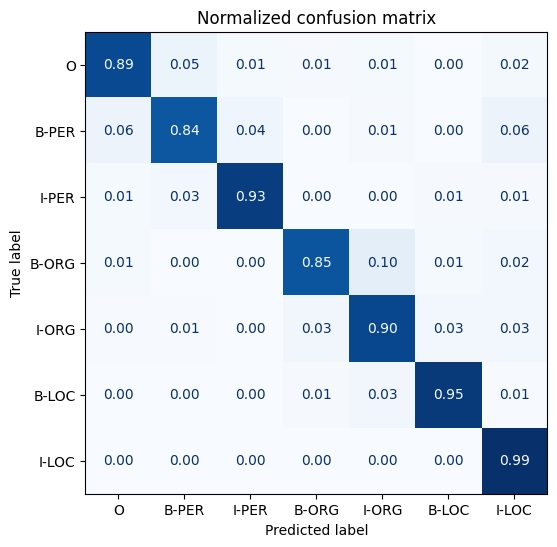

In [88]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],tags.names)

In [89]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,"preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.06,0.00,0.00,8.18,9.67,9.90,6.74,0.00,8.71,9.42,8.56,7.57,5.81,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.46,6.55,6.41,0.00,6.47,0.00,6.34,0.00,6.30,6.40,6.38,6.39,6.43,6.49,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.52,0.00,0.00,0.00,10.57,9.56,7.27,3.93,3.32,0.00,5.11,4.58,0.00,5.53,4.26,0.00,0.00


In [90]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.04,0.00,0.00,0.02,0.03,0.00,0.01,0.00


transferencia entre linguas. vamos aplicar nosso modelo treinado em alemao em frases em outras linguas via predict()

In [91]:
def get_f1_scores(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

testando em alemao

In [92]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_scores(trainer, panx_de_encoded["test"])
print(f"F1-score do modelo [de] com dataset[de]: {f1_scores['de']['de']:.3f}")

F1-score do modelo [de] com dataset[de]: 0.864


o modelo apresentou uma boa precisao, agora vamos testar em fr

In [93]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


vemos que mesmo com a mudança de lingua o modelo consegui identificar bem o tipo dos tokens. Agora vamos testar no dataset
completo em fr

In [94]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_scores(trainer, panx_ds["test"])

In [95]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score do modelo [de] com dataset[fr]: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score do modelo [de] com dataset[fr]: 0.697


vemos que ao mudar a lingua o modelo apresentou um perdar de 15 pontos na sua precisao. agora vamos testar com italiano

In [96]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score do modelo [de] com dataset[it]: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score do modelo [de] com dataset[it]: 0.686


treiando agora em ingles

In [97]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score do modelo [de] com dataset[en]: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score do modelo [de] com dataset[en]: 0.588


refinando o modelo, usando os mesmos hiperparametros mas usando logging_steps e selecionando o tamanho do set de treinamento

In [98]:
def train_on_subsets(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
                      data_collator=data_collator, compute_metrics=compute_metrics,
                      train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Treinamento completo")

    f1_score = get_f1_scores(trainer, test_ds)
    return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]})

para refinar com sucesso também precisamos encode o corpus com input_ids, mask de atençao e label_ids

In [99]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

testando a função e um set de treinamento pequeno com 250 exemplos

In [100]:
training_args.push_to_hub = False
metrics_df = train_on_subsets(panx_fr_encoded, 250)
metrics_df

C:\Users\alenu\AppData\Local\Temp\ipykernel_4160\1807306192.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.623500,1.297367,0.009217
2,1.192100,0.979465,0.215449
3,0.944700,0.882522,0.336204


,num_samples,f1_score
0,250,0.334614


refinando em multiplas linguas de uma só vez

In [104]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus


In [105]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

para o novo treinamento vamos usar os mesmos hiperparametros que usamos anteriormente, basta atualizar o loggin_steps,
model e dataset no trainer

In [106]:
training_args.loggin_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Treinamento completo")

C:\Users\alenu\AppData\Local\Temp\ipykernel_4160\1910587856.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.170800,0.179100,0.823670
2,0.127500,0.161669,0.847613
3,0.107000,0.163701,0.857507


CommitInfo(commit_url='https://huggingface.co/alek2k2k/xlm-roberta-base-finetuned-panx-de-fr/commit/b5f973409e99b1fd24932d44a4afe3e2bcd79e28', commit_message='Treinamento completo', commit_description='', oid='b5f973409e99b1fd24932d44a4afe3e2bcd79e28', pr_url=None, repo_url=RepoUrl('https://huggingface.co/alek2k2k/xlm-roberta-base-finetuned-panx-de-fr', endpoint='https://huggingface.co', repo_type='model', repo_id='alek2k2k/xlm-roberta-base-finetuned-panx-de-fr'), pr_revision=None, pr_num=None)

vendo como o modelo performa em cada lingua

In [109]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}]: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

F1-score of [de-fr] model on [de]: 0.867


F1-score of [de-fr] model on [fr]: 0.864


F1-score of [de-fr] model on [it]: 0.792


F1-score of [de-fr] model on [en]: 0.683


In [110]:
corpora = [panx_de_encoded]

#excluindo alemao da iteracao
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    #refinando em um corpus monolingua
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subsets(ds_encoded, ds_encoded["train"].num_rows)
    #coleta f1-scores
    f1_scores[lang][lang] = metrics["f1_score"][0]
    #adicionando o corpus de uma lingua em uma lista para ser concatenado
    corpora.append(ds_encoded)

C:\Users\alenu\AppData\Local\Temp\ipykernel_4160\1807306192.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.564700,0.307980,0.788109
2,0.272900,0.265264,0.825418
3,0.174900,0.275055,0.842602


C:\Users\alenu\AppData\Local\Temp\ipykernel_4160\1807306192.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.719100,0.289269,0.776385
2,0.267600,0.269672,0.801136
3,0.184000,0.252752,0.823241


C:\Users\alenu\AppData\Local\Temp\ipykernel_4160\1807306192.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,1.015900,0.505405,0.569452
2,0.474800,0.410355,0.671525
3,0.381400,0.407235,0.684855


concatenando os corpus em um unico corpora com todas as linguas

In [111]:
corpora_encoded = concatenate_splits(corpora)

In [112]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

C:\Users\alenu\AppData\Local\Temp\ipykernel_4160\306942408.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.292700,0.201043,0.807510
2,0.157400,0.173152,0.837977
3,0.103300,0.174643,0.852225


CommitInfo(commit_url='https://huggingface.co/alek2k2k/xlm-roberta-base-finetuned-panx-all/commit/750f61426a9bd50cfc8c5321b6a1a8b93438ee36', commit_message='Training completed!', commit_description='', oid='750f61426a9bd50cfc8c5321b6a1a8b93438ee36', pr_url=None, repo_url=RepoUrl('https://huggingface.co/alek2k2k/xlm-roberta-base-finetuned-panx-all', endpoint='https://huggingface.co', repo_type='model', repo_id='alek2k2k/xlm-roberta-base-finetuned-panx-all'), pr_revision=None, pr_num=None)

gerando as prediçoes em cada lingua de cada um dos sets de test

In [114]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_scores(trainer, corpora[idx]["test"])

scores_data = {"de": f1_scores["de"],"each":{lang: f1_scores[lang][lang] for lang in langs},"all": f1_scores["all"]}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on", inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8645,0.6966,0.6857,0.5879
each,0.8645,0.8475,0.8225,0.6981
all,0.8658,0.8662,0.8576,0.7733
